In [2]:
from nilearn import plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nilearn import image,surface,datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn.plotting import show
from nilearn.image import math_img,load_img,index_img
import seaborn as sns
import networkx as nx
import colorcet as cc
import random
import bct
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
from scipy import stats

TR=1.3
excludeHead=10
excludeTail=-6
%matplotlib inline

custom_colors=['crimson','darkorange','olivedrab','dodgerblue','blueviolet']
sns.set(font_scale=1.5)
sns.set_style('white')


In [7]:
projectfolder='path_to_project_root'
resultfolder=projectfolder+'hmm/'
extractDataFolder=projectfolder+'/postprocessing4/extract/'
excludeSession=[]
decodedModel='decodedStateSequence.csv'

In [13]:
decodedTC=pd.read_csv(resultfolder+decodedModel,index_col=None,dtype={'subid': str})
decodedTC['subid']=decodedTC.apply(lambda r: 'sub-'+r['subid'],axis=1)
decodedTC['newtask']=decodedTC.apply(lambda r: r['task'].replace('ta1','ta').replace('ta2','ta'), axis=1)
nstate=len(decodedTC['state'].unique())
statelist=[str(i) for i in range(nstate)]
decodedTC.head()

,subid,task,state,0,1,2,3,4,5,6,7,newtask
0,sub-01,rest,6,0.009,0.027,0.160,0.000,0.014,0.052,0.687,0.051,rest
1,sub-01,rest,6,0.142,0.142,0.018,0.000,0.008,0.016,0.654,0.021,rest
2,sub-01,rest,6,0.309,0.304,0.001,0.000,0.009,0.002,0.368,0.007,rest
3,sub-01,rest,6,0.411,0.330,0.001,0.001,0.006,0.002,0.240,0.008,rest
4,sub-01,rest,6,0.386,0.200,0.002,0.192,0.001,0.003,0.207,0.009,rest


In [4]:
avg_by_task=decodedTC.groupby('task').mean(numeric_only=True)[statelist]
dist_PerSub=decodedTC.groupby(['subid','task']).mean(numeric_only=True)[statelist]

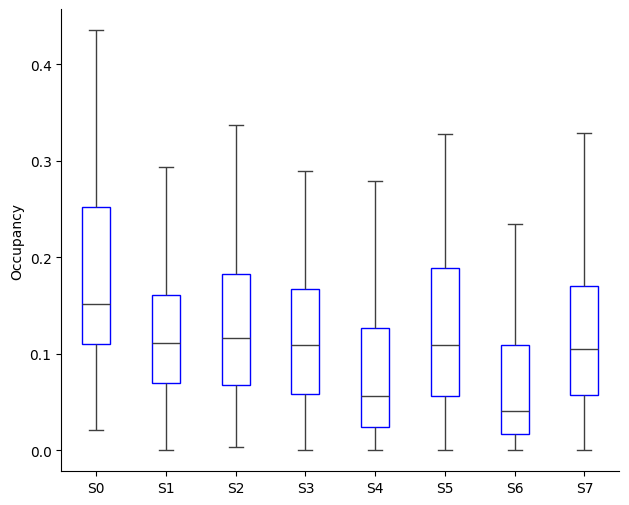

In [12]:
fig,ax=plt.subplots(1,figsize=(nstate*.9,6))
sns.boxplot(data=dist_PerSub.reset_index().melt(id_vars=['subid','task']),x='variable',y='value',
                 ax=ax,showfliers=False,width=0.4,boxprops=dict(facecolor="none", edgecolor="blue"))
ax.set_ylabel('Occupancy')
ax.set_xlabel('')
sns.despine()
plt.xticks(ticks=range(nstate), labels=[f'S{x}' for x in range(nstate)])
plt.show()
plt.close()

In [9]:
#get dwell time
decodedTC['chgflg']=decodedTC['state'].diff().astype(bool).fillna(0)
decodedTC['timeslice']=1
for i,g in decodedTC.groupby(['subid','task']):
    decodedTC.loc[(decodedTC['subid']==i[0])&(decodedTC['task']==i[1]),
    'timeslice']=decodedTC.loc[(decodedTC['subid']==i[0])&(decodedTC['task']==i[1]),'timeslice'].cumsum()
decodedTC.loc[decodedTC['timeslice']==1,'chgflg']=True #new state run when switch session
decodedTC['chgflg']=decodedTC['chgflg'].astype(int).cumsum()
statecnt=decodedTC.groupby(['state','chgflg','newtask','task']).count()['timeslice']
maxdur=decodedTC['timeslice'].max()

In [10]:
duration_avg=np.round((statecnt.groupby(level=[0,2]).mean()*TR).reset_index().pivot(index='state',
                                                                                    columns='newtask', values='timeslice').T,1).fillna('')
duration_avg

state,0,1,2,3,4,5,6,7
newtask,,,,,,,,
rest,7.2,7.0,6.3,7.0,8.6,8.0,7.7,8.2
ta,6.0,6.8,6.9,6.1,9.4,6.3,14.9,6.6


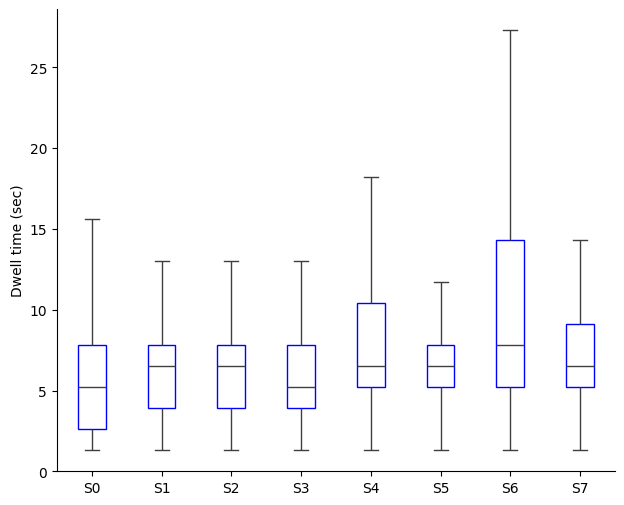

In [42]:
includedstates=[int(x) for x in statelist]
fig,ax=plt.subplots(1,figsize=(nstate*.9,6))
sns.boxplot(data=(statecnt[statecnt.index.get_level_values('state').isin(includedstates)]*TR).reset_index(),x='state',y='timeslice',
            showfliers=False,width=0.4,boxprops=dict(facecolor="none", edgecolor="blue"),ax=ax)
ax.set_ylabel('Dwell time (sec)')
ax.set_xlabel('')
plt.xticks(ticks=range(nstate), labels=[f'S{x}' for x in range(nstate)])
sns.despine()
plt.show()
plt.close()

## Cortical surface

In [202]:
fsaverage = datasets.fetch_surf_fsaverage()
#right order
yeo_17_network_names=['VisCent','VisPeri','SomMotA','SomMotB','DorsAttnA','DorsAttnB','SalVentAttnA','SalVentAttnB',
                     'LimbicA','LimbicB','ContC','ContA','ContB','TempPar','DefaultC','DefaultA','DefaultB']

mask_img=datasets.fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=17, resolution_mm=2)

atlas_filename = mask_img.maps
yeo_labels = mask_img.labels 
brain_masker = NiftiLabelsMasker(labels_img=atlas_filename, smoothing_fwhm=6, detrend=True, 
                        low_pass=0.1, high_pass=0.01, t_r=TR, 
                                 #standardize="zscore_sample",
                                 standardize=False,memory="nilearn_cache", memory_level=2)
brain_masker.fit()
labels = [label.decode("utf-8") if isinstance(label, bytes) else label for label in yeo_labels]

# Extract Yeo network IDs (1 to 17) for each parcel from the Schaefer labels
yeo_network_ids=[x.split('_')[2] for x in labels]

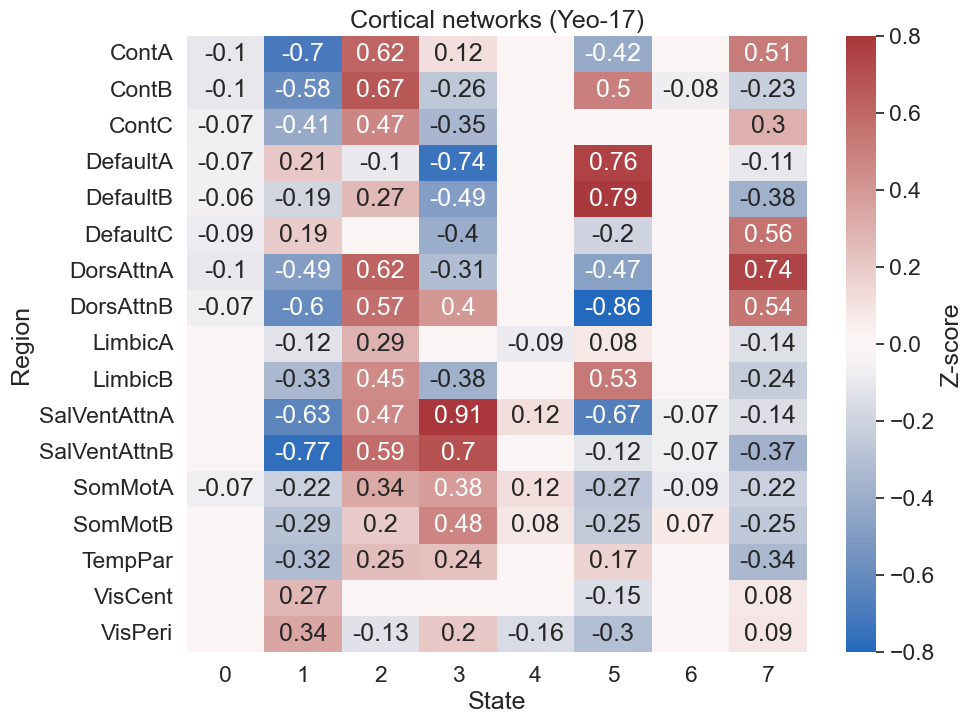

In [137]:
yeoFolder=extractDataFolder+'Yeo17/'
allYeo17Data=pd.DataFrame()
includeTasks=['ta1','ta2','rest']
for subid,x in decodedTC.groupby('subid'):
    for task, g in x.groupby('task'):
        if task not in includeTasks:continue
        #subdata=pd.read_csv(schaeferDataFolder+subid+'_'+task+'.csv',index_col=None)
        tmpdata=pd.read_csv(yeoFolder+subid.split('-')[1]+'_'+task+'.csv',index_col=None)
        tmpdata.columns=yeo_17_network_names
        tmpdata=tmpdata.iloc[excludeHead:excludeTail]
        tmpdata['state']=g['state'].values
        tmpdata['session']=subid+task
        allYeo17Data=pd.concat([allYeo17Data,tmpdata])
corticaldata=allYeo17Data.groupby('state').mean(numeric_only=True).T.sort_index()
allYeo17Data.set_index('session',inplace=True)
allindex=allYeo17Data.index.unique()
indexlist=list(range(len(allindex)))
allMeans=[]
for i in range(2000):
    random.shuffle(indexlist)
    allYeo17Data['shuffled']=allYeo17Data.loc[allindex[indexlist],'state'].values
    allMeans.append(allYeo17Data.groupby('shuffled').mean()[yeo_17_network_names].values.tolist())
allMeans=np.array(allMeans)
allYeo17Data.drop(columns=['shuffled'],inplace=True)
cilower=pd.DataFrame(np.quantile(allMeans,.025/17,axis=0),columns=yeo_17_network_names,index=statelist).T.sort_index()
ciupper=pd.DataFrame(np.quantile(allMeans,1-.025/17,axis=0),columns=yeo_17_network_names,index=statelist).T.sort_index()
cilower.columns=corticaldata.columns
ciupper.columns=corticaldata.columns
mask = ~((corticaldata > ciupper) | (corticaldata < cilower))
filtered_data = corticaldata.mask(mask, other=0)
annot = np.round(filtered_data,2).astype(str).values  # Convert values to string for annotations
annot[mask.values] = ""  # Blank out annotations for masked cells

plt.figure(figsize=(10, 8))
sns.heatmap(filtered_data,cmap="vlag",annot=annot, fmt="", cbar_kws={'label': 'Z-score'},vmin=-.8,vmax=.8)
plt.title("Cortical networks (Yeo-17)")
plt.xlabel("State")
plt.ylabel("Region")
plt.show()
plt.close()

## Subcortical

In [244]:
ho_label=['Left Cerebral White Matter', 'Left Cerebral Cortex', 'Left Lateral Ventricle', 'Left Thalamus', 'Left Caudate', 'Left Putamen', 'Left Pallidum', 'Brain-Stem', 'Left Hippocampus', 'Left Amygdala', 'Left Accumbens', 'Right Cerebral White Matter', 'Right Cerebral Cortex', 'Right Lateral Ventricle', 'Right Thalamus', 'Right Caudate', 'Right Putamen', 'Right Pallidum', 'Right Hippocampus', 'Right Amygdala', 'Right Accumbens']
coresublabel=set(x.replace('Left ','').replace('Right ','') for x in ho_label)
coresublabeldict=dict([(l,([suffix+l for suffix in ['Left ','Right ']] if l!='Brain-Stem' else [l])) for l in coresublabel])

In [246]:
subcorticalDataFolder=extractDataFolder+'subcortical/'
allsubcortical=pd.DataFrame()
includeTasks=['ta1','ta2','rest']
for subid,x in decodedTC.groupby('subid'):
    for task, g in x.groupby('task'):
        if task not in includeTasks:continue
        tmpdata=pd.DataFrame()
        subdata=pd.read_csv(subcorticalDataFolder+subid.split('-')[1]+'_'+task+'.csv',index_col=None)
        subdata=subdata.iloc[excludeHead:excludeTail]
        for c in coresublabel:
            tmpdata[c]=subdata[coresublabeldict[c]].mean(axis=1)
        tmpdata['state']=g['state'].values
        tmpdata['session']=subid+task
        allsubcortical=pd.concat([allsubcortical,tmpdata])
allsubcortical.drop(columns=['Cerebral Cortex','Lateral Ventricle','Cerebral White Matter'],inplace=True)

In [248]:
subcorticaldata=allsubcortical.groupby('state').mean(numeric_only=True).T
subcortical_network_ids=[x for x in coresublabeldict.keys() if x not in ['Cerebral Cortex','Lateral Ventricle','Cerebral White Matter']]
allsubcortical.set_index('session',inplace=True)
allindex=allsubcortical.index.unique()
indexlist=list(range(len(allindex)))
allMeans=[]
for i in range(2000):
    random.shuffle(indexlist)
    allsubcortical['shuffled']=allsubcortical.loc[allindex[indexlist],'state'].values
    allMeans.append(allsubcortical.groupby('shuffled').mean()[subcortical_network_ids].values.tolist())
allMeans=np.array(allMeans)
allsubcortical.drop(columns=['shuffled'],inplace=True)
cilower=pd.DataFrame(np.quantile(allMeans,.025/len(subcortical_network_ids),axis=0),columns=subcortical_network_ids,index=statelist).T

ciupper=pd.DataFrame(np.quantile(allMeans,1-.025/len(subcortical_network_ids),axis=0),columns=subcortical_network_ids,index=statelist).T
cilower.columns=subcorticaldata.columns
ciupper.columns=subcorticaldata.columns

mask = ~((subcorticaldata > ciupper) | (subcorticaldata < cilower))
filtered_data = subcorticaldata.mask(mask, other=0)
annot = np.round(filtered_data,2).astype(str).values  # Convert values to string for annotations
annot[mask.values] = ""  # Blank out annotations for masked cells

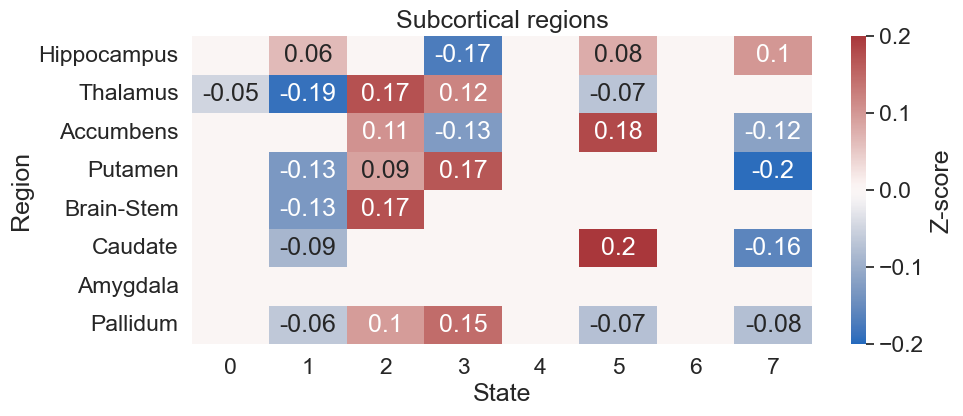

In [252]:

plt.figure(figsize=(10, 4))
sns.heatmap(filtered_data,cmap="vlag",annot=annot, fmt="", cbar_kws={'label': 'Z-score'},vmin=-.2,vmax=.2)
plt.title("Subcortical regions")
plt.xlabel("State")
plt.ylabel("Region")
plt.show()
plt.close()

In [65]:
#compute pvalues, bonferroni corrected, for hippocampus
hippocampalDist=np.abs(allMeans[:,:,0])
hippocampalMean=subcorticaldata.loc['Hippocampus'].values
for i in range(nstate):
    print(f"S{i}: p = {len(hippocampalDist[:,i][hippocampalDist[:,i]>np.abs(hippocampalMean[i])])/len(hippocampalDist)*8}")

S0: p = 0.2
S1: p = 0.016
S2: p = 2.312
S3: p = 0.0
S4: p = 0.304
S5: p = 0.0
S6: p = 5.988
S7: p = 0.0


In [125]:
hippoDataFolder=extractDataFolder+'hippo/'
lefthippodata=pd.DataFrame()
righthippodata=pd.DataFrame()
includeTasks=['ta1','ta2','rest']
#includeTasks=['ta1','ta2']
for subid,x in decodedTC.groupby('subid'):
    for task, g in x.groupby('task'):
        if task not in includeTasks:continue
        tmpdata=pd.DataFrame()
        subdata=pd.read_csv(hippoDataFolder+subid.split('-')[1]+'_'+task+'.csv',index_col=None)
        subdata=subdata.iloc[excludeHead:excludeTail]
        leftcols=[x for x in subdata.columns if x[:4]=='left']
        rightcols=[x for x in subdata.columns if x[:4]=='righ']
        tmpdata=subdata.loc[:,leftcols]
        tmpdata['state']=g['state'].values
        tmpdata['session']=subid+task
        lefthippodata=pd.concat([lefthippodata,tmpdata])
        tmpdata=subdata.loc[:,rightcols]
        tmpdata['state']=g['state'].values
        tmpdata['session']=subid+task
        righthippodata=pd.concat([righthippodata,tmpdata])

In [126]:
tmp=righthippodata.groupby(['state','session']).mean(numeric_only=True)
tmp.columns=[int(eval(x.split('_')[1])) for x in tmp.columns]
tmp=tmp.droplevel('session')
normalized_cols = (tmp.columns - tmp.columns.min()) / (tmp.columns.max() - tmp.columns.min())
bucket_edges = np.linspace(0, 1, 11)  # 11 edges = 10 buckets
bucket_labels = np.round(bucket_edges[:-1] + 0.05, 2)  # Center labels at 0.05, 0.15, etc.
col_to_bucket = pd.cut(normalized_cols, bins=bucket_edges, labels=bucket_labels, include_lowest=True)
df_buckets = pd.DataFrame()
for bucket in bucket_labels:
    cols_in_bucket = tmp.columns[col_to_bucket == bucket]
    if len(cols_in_bucket) > 0:
        df_buckets[bucket] = tmp[cols_in_bucket].mean(axis=1)  # Average across the bucket columns
df_long = df_buckets.reset_index().melt(id_vars='state', var_name='timepoint', value_name='value')
tmp=lefthippodata.groupby(['state','session']).mean(numeric_only=True)
tmp.columns=[int(eval(x.split('_')[1])) for x in tmp.columns]
tmp=tmp.droplevel('session')
normalized_cols = (tmp.columns - tmp.columns.min()) / (tmp.columns.max() - tmp.columns.min())
bucket_edges = np.linspace(0, 1, 11)  # 11 edges = 10 buckets
bucket_labels = np.round(bucket_edges[:-1] + 0.05, 2)  # Center labels at 0.05, 0.15, etc.
col_to_bucket = pd.cut(normalized_cols, bins=bucket_edges, labels=bucket_labels, include_lowest=True)
df_buckets = pd.DataFrame()
for bucket in bucket_labels:
    cols_in_bucket = tmp.columns[col_to_bucket == bucket]
    if len(cols_in_bucket) > 0:
        df_buckets[bucket] = tmp[cols_in_bucket].mean(axis=1)  # Average across the bucket columns
df_long=pd.concat([df_long,df_buckets.reset_index().melt(id_vars='state', var_name='timepoint', value_name='value')])


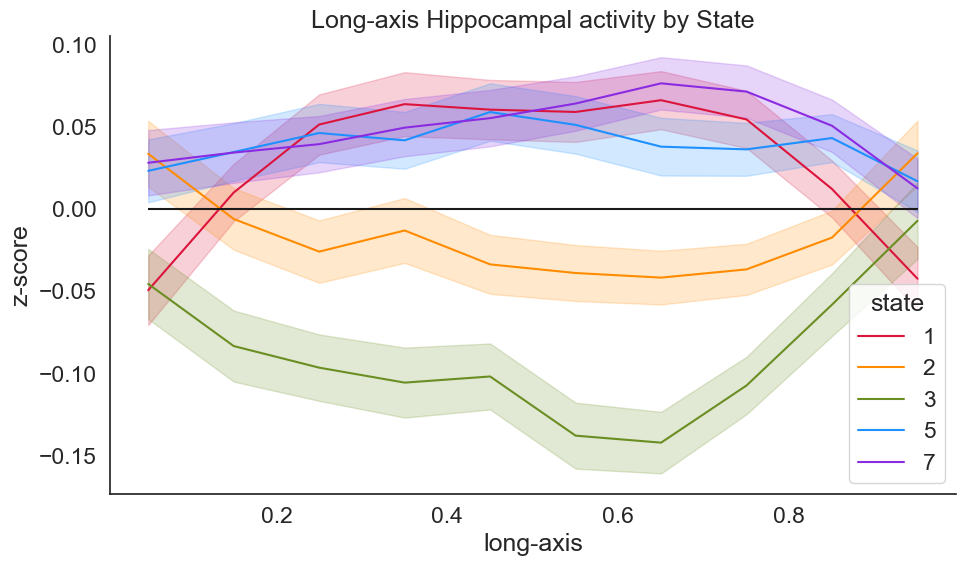

In [129]:
fig,ax=plt.subplots(1,figsize=(10,6))
sns.lineplot(
    data=df_long[df_long['state'].isin([1,2,3,5,7])],
    x='timepoint',
    y='value',
    hue='state',palette=custom_colors,
    errorbar='se'  # or use 'ci' for confidence interval
)
sns.despine()
plt.hlines(y=0,xmin=0.05,xmax=.95,colors='k')
plt.title('Long-axis Hippocampal activity by State')
plt.xlabel('long-axis')
plt.ylabel('z-score')
plt.tight_layout()
plt.show()

## Connectivity 400

In [157]:
n_rois=400
triu_indices = np.triu_indices(n_rois, k=1)
correlation_measure = ConnectivityMeasure(kind='correlation')

In [161]:
schaeferDataFolder=extractDataFolder+'schaefer400/'
all400Data=pd.DataFrame()
includeTasks=['ta1','ta2','rest'] #need all sessions to have significant effect of states upon modularity
valuecolumns=[str(x) for x in range(400)]
for subid,x in decodedTC.groupby('subid'):
    for task, g in x.groupby('task'):
        if task not in includeTasks:continue
        tmpdata=pd.DataFrame()
        subdata=pd.read_csv(schaeferDataFolder+subid.split('-')[1]+'_'+task+'.csv',index_col=None)
        subdata=subdata.iloc[excludeHead:excludeTail]
        subdata['state']=g['state'].values
        subdata['subid']=subid
        subdata['task']=task
        all400Data=pd.concat([all400Data,subdata])

In [165]:
all400Data['session']=all400Data.apply(lambda r: r['subid']+r['task'],axis=1)
modularityDF=pd.DataFrame(columns=statelist,index=all400Data['subid'].unique())
efficiencyDF=pd.DataFrame(columns=statelist,index=all400Data['subid'].unique())

In [ ]:
for sub,g in all400Data.groupby('subid'):
    modularity=[]
    print(sub)
    for s in statelist:
        dataforstate=g.loc[g['state']==int(s),valuecolumns].values
        if len(dataforstate)==0:continue
        correlation_matrix=correlation_measure.fit_transform([dataforstate])[0]
        correlation_matrix[correlation_matrix < 0] = 0
        #pc=bct.participation_coef(correlation_matrix, yeo_network_ids)
        modularityDF.loc[sub,s]=bct.modularity.modularity_und(correlation_matrix, gamma=1, kci=np.unique(yeo_network_ids, return_inverse=True)[1])[1]
        efficiencyDF.loc[sub,s] =  bct.efficiency_wei(correlation_matrix)

In [176]:
selectedStates=['1','2','3','5','7']
displaystates=['S'+s for s in selectedStates]
df_long = modularityDF[['1','2','3','5','7']].rename(columns=dict([(s,'S'+s) for s in selectedStates])).reset_index().dropna().melt(
    id_vars=['index'],var_name="State", value_name="Modularity")
df_long['State']=df_long['State'].astype("category")
df_long['Modularity']=df_long['Modularity'].astype(float)

In [178]:
model = smf.mixedlm("Modularity ~ State", df_long, groups=df_long["index"])
result = model.fit()
print(result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Modularity
No. Observations: 230     Method:             REML      
No. Groups:       46      Scale:              0.0002    
Min. group size:  5       Log-Likelihood:     583.9821  
Max. group size:  5       Converged:          Yes       
Mean group size:  5.0                                   
--------------------------------------------------------
               Coef. Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.090    0.003 26.034 0.000  0.083  0.097
State[T.S2]    0.005    0.003  1.754 0.079 -0.001  0.011
State[T.S3]    0.019    0.003  6.651 0.000  0.013  0.024
State[T.S5]    0.028    0.003  9.832 0.000  0.022  0.034
State[T.S7]    0.024    0.003  8.494 0.000  0.019  0.030
Group Var      0.000    0.007                           



/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


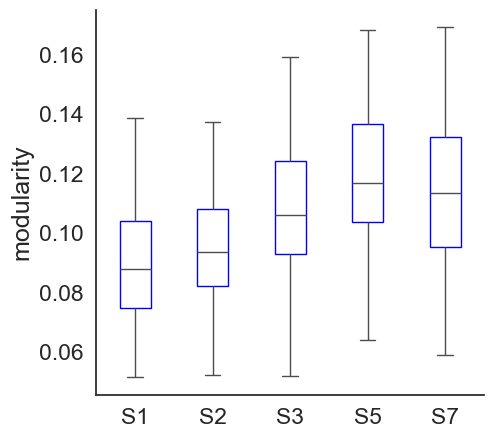

In [186]:
ax=plt.subplots(1,figsize=(5,5))
sns.boxplot(data=df_long,x='State',y='Modularity',width=0.4,showfliers=False,
           boxprops=dict(facecolor="none", edgecolor="blue"))
#sns.swarmplot(data=df_long,x='State',y='Modularity')
sns.despine()
plt.xlabel('')
plt.ylabel('modularity')
plt.show()
plt.close()

In [188]:
df_long = efficiencyDF[selectedStates].rename(columns=dict([(s,'S'+s) for s in selectedStates])).reset_index().dropna().melt(
    id_vars=['index'],var_name="State", value_name="Efficiency")
df_long['Condition']=df_long['State'].astype("category")
df_long['Efficiency']=df_long['Efficiency'].astype(float)
model = smf.mixedlm("Efficiency ~ State", df_long, groups=df_long["index"])
result = model.fit()
print(result.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Efficiency
No. Observations: 230     Method:             REML      
No. Groups:       46      Scale:              0.0002    
Min. group size:  5       Log-Likelihood:     587.9605  
Max. group size:  5       Converged:          Yes       
Mean group size:  5.0                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.239    0.003 74.626 0.000  0.233  0.245
State[T.S2]   -0.003    0.003 -0.942 0.346 -0.008  0.003
State[T.S3]   -0.007    0.003 -2.371 0.018 -0.012 -0.001
State[T.S5]   -0.009    0.003 -3.159 0.002 -0.015 -0.003
State[T.S7]   -0.004    0.003 -1.543 0.123 -0.010  0.001
Group Var      0.000    0.006                           



/opt/anaconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


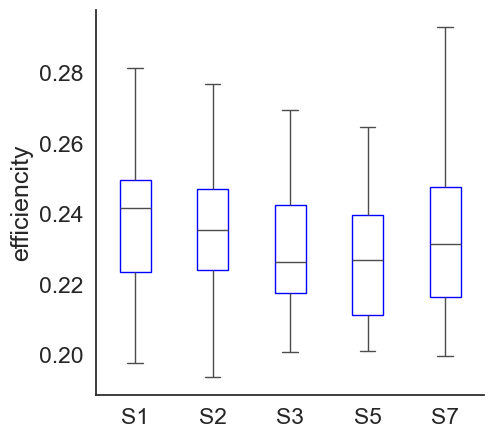

In [192]:
ax=plt.subplots(1,figsize=(5,5))
sns.boxplot(data=df_long,x='Condition',y='Efficiency',width=0.4,showfliers=False,
           boxprops=dict(facecolor="none", edgecolor="blue"))
#sns.swarmplot(data=df_long,x='Condition',y='Efficiency')
sns.despine()
plt.xlabel('')
plt.ylabel('efficiencity')
plt.show()
plt.close()

## Surface plot

In [214]:
def makeSurfacePlot2(average_img,title,threshold=None,vmin=-.05,vmax=.05,showbar=False):
    # Extract the specific component as a 3D image
    fig, ax = plt.subplots(1,2,figsize=(4, 6),subplot_kw={'projection': '3d'},
                           gridspec_kw=dict(top=1,left=0, right=1, bottom=0),layout='compressed')
    # Project the component to the right hemisphere's surface
    texture_right = surface.vol_to_surf(average_img, fsaverage.pial_right)
    # Project the component to the right hemisphere's surface
    texture_left = surface.vol_to_surf(average_img, fsaverage.pial_left)
    # Plot medial view for the right hemisphere
    plotting.plot_surf_stat_map(
        fsaverage.infl_left, texture_left, hemi='left', view='medial',vmin=vmin,vmax=vmax,
        colorbar=showbar,bg_map=fsaverage.sulc_left,axes=ax[1],
        threshold=threshold)

    # Plot lateral view for the left hemisphere
    plotting.plot_surf_stat_map(
        fsaverage.infl_left, texture_left, hemi='left', view='lateral',vmin=vmin,vmax=vmax,
        colorbar=False,bg_map=fsaverage.sulc_left,axes=ax[0],
        threshold=threshold  # Adjust threshold to highlight significant areas
    )
    fig.suptitle(title,y=0.65)

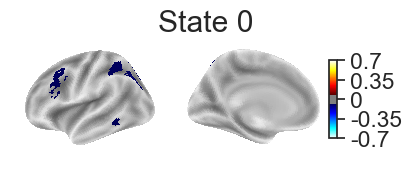

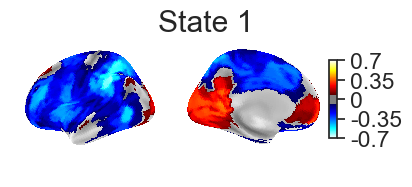

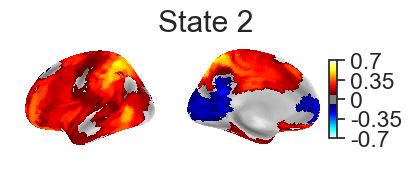

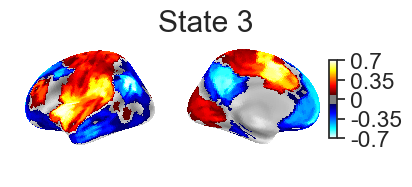

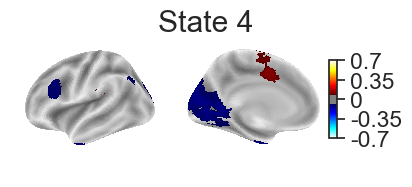

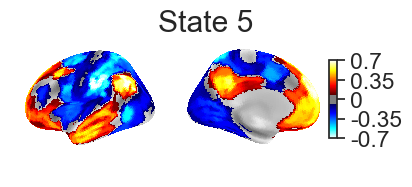

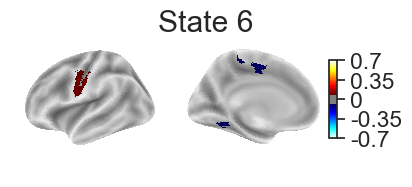

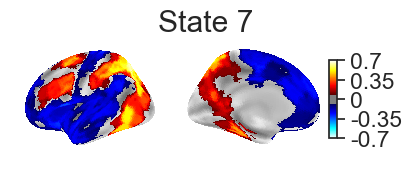

In [216]:
for s in statelist:
    average_data = all400Data.loc[all400Data['state']==int(s),valuecolumns].mean()
    average_img = brain_masker.inverse_transform(average_data)
    makeSurfacePlot2(average_img,'State '+s,threshold=.08,vmin=-.7,vmax=.7,showbar=True)
    show()

## Transition graph

In [224]:
def makeTransitionGraph(statelist,labels,transprob,throttlelevel,palette=None,widthmult=150,const=-5,showplot=True,colormap=None):
    nstate=len(statelist)
    if colormap==None:
        if palette==None:
            #palette = sns.color_palette() # Default color palette
            palette = sns.color_palette(cc.glasbey, n_colors=10)
        cmap=dict(zip(statelist,palette[:nstate])) 
    else:
        cmap=colormap
    plt.figure(figsize=(8,8))
    G=nx.DiGraph()
    for i in statelist:
        G.add_node(i)
    edgelabels={}
    for i in statelist:
        for j in statelist:
            if i==j: continue
            w=transprob.loc[i,j]
            if w <throttlelevel:continue
            G.add_edge(i,j,weight=w*widthmult+const)
            edgelabels[(i,j)]=np.round(w,2)
    colors=[cmap[e[0]] for e in G.edges]
    pos=nx.circular_layout(G)
    weight=nx.get_edge_attributes(G,'weight')
    if showplot:
        nx.draw_networkx_nodes(G,pos,node_color=[cmap[x] for x in statelist],node_size=500,alpha=.2)
        nx.draw_networkx_labels(G,pos,dict(zip(statelist,labels)),font_size=20,font_color=cmap,font_weight=20)
        #nx.draw_networkx_labels(G,pos,dict(zip(statelist,labels)),font_size=20,font_color='black')
        nx.draw_networkx_edges(G,pos,width=list(weight.values()),alpha=.5,arrowsize=25,edge_color=colors,connectionstyle='arc3, rad=0.1')
        plt.axis('off')
        plt.show()
    return G


In [218]:
includedstates=['1','2','3','5','7']
transprob=pd.DataFrame(0,columns=includedstates,index=includedstates)
includedTask=['ta1','ta2','rest']
for i,g in decodedTC[decodedTC['state'].astype(str).isin(includedstates)].groupby(['subid','task']):
    if i[1] not in includedTask:continue
    tmp=g[['state','newtask']].copy()
    tmp['nxtstate']=g['state'].astype(str).shift(-1)
    tmp.dropna(inplace=True)
    tmp[['state','nxtstate']]=tmp[['state','nxtstate']].astype(str)
    tmp=tmp.groupby(['state','nxtstate']).count()['newtask']
    transprob=transprob+tmp.unstack(level=1).reindex(columns=includedstates,index=includedstates).fillna(0)
transprob=transprob.div(transprob.sum(axis=1),axis=0)

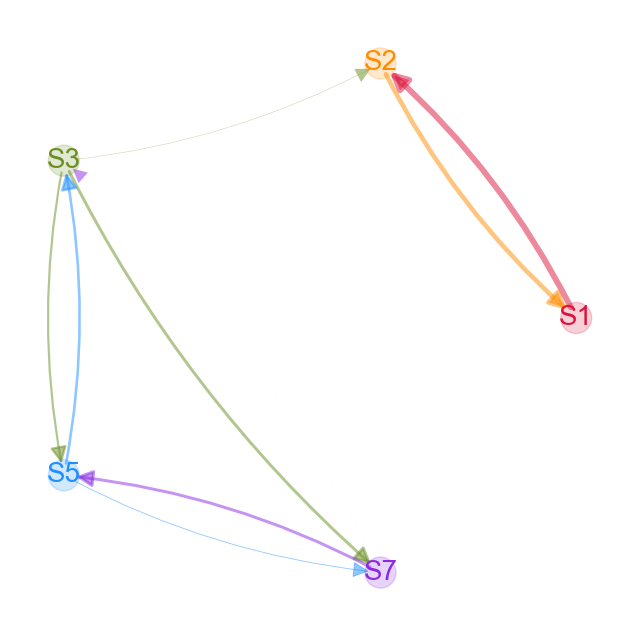

In [226]:
#statelist_reorder=statelist
nodelabels=['S'+s for s in includedstates]
throttlelevel=.037
makeTransitionGraph(includedstates,nodelabels,transprob,throttlelevel,widthmult=120,const=-5,
                    colormap={'1':'crimson','2':'darkorange','3':'olivedrab','5':'dodgerblue','7':'blueviolet'})

In [228]:
#community
G=makeTransitionGraph(includedstates,nodelabels,transprob,throttlelevel=0,widthmult=1,const=0, showplot=False)
nx.community.louvain_communities(G,seed=5)

[{'1', '2'}, {'3', '5', '7'}]

## Correlate with FD

In [232]:
timelist=np.array(range(20,317))*TR  

allData=pd.DataFrame(columns=['subid','task']+statelist)
for filename in os.listdir(projectfolder+'framewise_displacement/'):
    if os.path.isfile(os.path.join(projectfolder+'framewise_displacement/', filename)):
        # Get the filename without the extension
        f = os.path.splitext(filename)[0]
        subid=f.split('_')[0]
        task=f.split('_')[1].split('-')[1]
        hmmDecode=decodedTC[(decodedTC['subid']==subid)&(decodedTC['task']==task)]
        if len(hmmDecode)==0:continue
        signalData=pd.read_csv(projectfolder+'framewise_displacement/'+filename,index_col=None).dropna()
        signalData=signalData.loc[10:]
        signalData=signalData.iloc[excludeHead:excludeTail]
        #signalData['subid']
        signalData['subid']=subid
        signalData['task']=task
        signalData[statelist]=hmmDecode[statelist].values
        signalData['time']=timelist
        allData=pd.concat([allData,signalData])

/var/folders/f4/kqf7rn397cj8ynryplksbjvm0000gr/T/ipykernel_32703/801199056.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  allData=pd.concat([allData,signalData])


In [234]:
tmp=allData[allData['task']=='rest']
resultDF=pd.DataFrame(index=['rest','ta'],columns=statelist)
for c in statelist:
    corr,p=stats.pearsonr(tmp[c],tmp['framewise_displacement'])
    resultDF.loc['rest',c]=corr
    print(f"{c}: {corr:.2f}({p:.3f})")

0: 0.09(0.000)
1: -0.01(0.152)
2: 0.01(0.136)
3: -0.01(0.299)
4: -0.03(0.000)
5: -0.03(0.001)
6: -0.03(0.000)
7: -0.02(0.024)


In [236]:
tmp=allData[allData['task']!='rest']
for c in statelist:
    corr,p=stats.pearsonr(tmp[c],tmp['framewise_displacement'])
    resultDF.loc['ta',c]=corr
    print(f"{c}: {corr:.2f}({p:.3f})")

0: 0.04(0.000)
1: -0.01(0.032)
2: -0.02(0.000)
3: -0.06(0.000)
4: 0.03(0.000)
5: -0.05(0.000)
6: 0.11(0.000)
7: -0.06(0.000)


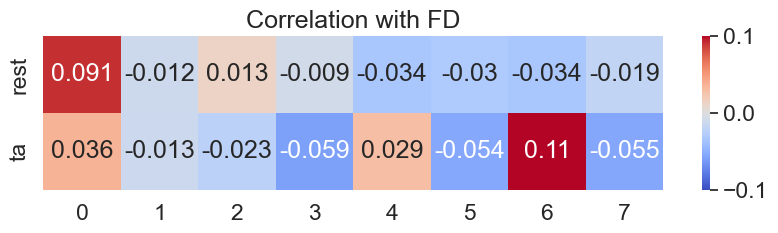

In [242]:
fig,ax=plt.subplots(figsize=(10,2))
sns.heatmap(np.round(resultDF.astype(float),3), annot=True, cmap="coolwarm",vmin=-.1,vmax=.1)
ax.set_title('Correlation with FD')
plt.show()

# Stability -- Compare with different model 

In [263]:
modelbase=decodedModel.split('.')[0]

modeltarget='alternativemodel'

decodedTCbase=pd.read_csv(resultfolder+modelbase+'.csv',index_col=None,dtype={'subid': str})
decodedTCbase=decodedTCbase[decodedTCbase['task']!='rest'].set_index(['subid','task'])
nstate=len(decodedTCbase['state'].unique())
statelist=[str(i) for i in range(nstate)]

decodedTCtarget=pd.read_csv(resultfolder+modeltarget+'.csv',index_col=None,dtype={'subid': str})
decodedTCtarget=decodedTCtarget[decodedTCtarget['task']!='rest'].set_index(['subid','task'])
nstate_target=len(decodedTCtarget['state'].unique())
statelist_target=[str(i) for i in range(nstate_target)]

In [265]:
corrDF=pd.DataFrame(np.nan,index=decodedTCtarget.index.unique(), columns=[x+'-'+y for x in statelist for y in statelist_target])
for i,g in decodedTCtarget.groupby(decodedTCtarget.index):
    for x in statelist:
        for y in statelist_target:
            corr,p=stats.pearsonr(g[y],decodedTCbase.loc[i,x])
            corrDF.loc[i,x+'-'+y]=corr
tmp=corrDF.mean()
meancorr=pd.DataFrame(np.nan,index=statelist,columns=statelist_target)
for x in statelist:
    for y in statelist_target:
        meancorr.loc[x,y]=tmp[x+'-'+y]

/var/folders/f4/kqf7rn397cj8ynryplksbjvm0000gr/T/ipykernel_32703/3653609690.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr,p=stats.pearsonr(g[y],decodedTCbase.loc[i,x])


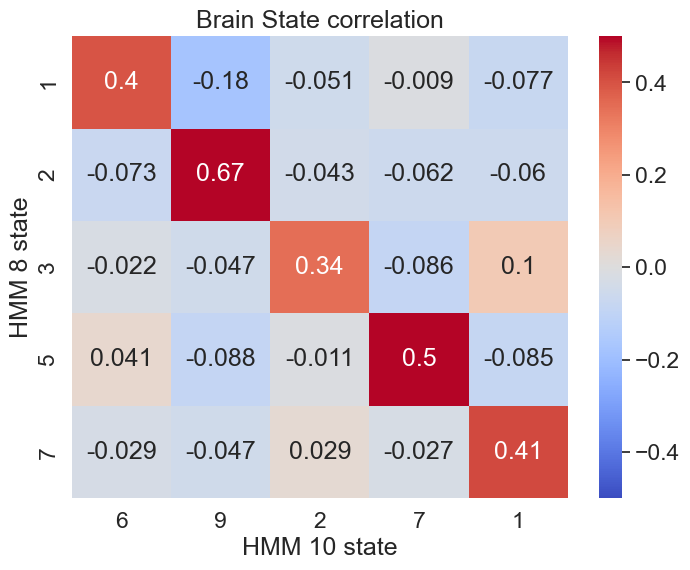

In [273]:
resorted_column=['6','9','2','7','1']
selectrows=['1','2','3','5','7']
fig,ax=plt.subplots(figsize=(8,6))
sns.heatmap(np.round(meancorr.astype(float).loc[selectrows,resorted_column],3), annot=True, cmap="coolwarm",vmin=-.5,vmax=.5)
ax.set_title('Brain State correlation')
plt.xlabel("HMM 10 state")
plt.ylabel("HMM 8 state")
plt.show()
plt.close()